<a href="https://colab.research.google.com/github/Catherine-Nguyen88/project_voting/blob/main/DS3001_Project_3_Report_(Group_17).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**`DS3001 Project 2 (Group 17)`**

Isabella Dressel, Camila Gutierrez, Catherine Nguyen, Rhiannon Staley

In [1]:
! git clone https://github.com/Catherine-Nguyen88/project_voting

Cloning into 'project_voting'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 296 (delta 27), reused 11 (delta 11), pack-reused 257
Receiving objects: 100% (296/296), 70.69 MiB | 8.35 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Updating files: 100% (68/68), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression


# **Summary**

# **Data**


# **Results**

We build a decision tree regression model to predict the outcome of the 2024 election in Virginia between Democratic and Republican candidates. We train and test our model using randomly selected election results in counties from 2008 to 2020, reporting the Rsq and RMSE to evaluate our model. We then use our model to predict the 2024 election based on county-level demographics from the 2018-2022 ACS.

In [3]:
# this is the final df we are using
net_count = pd.read_csv('/content/project_voting/net_votes.csv')
df = net_count.copy() # rename to df
df.head()

,index,year,state,state_po,county_name,county_fips,office,candidatevotes,totalvotes,mode,...,Female: 62 to 64 years,Female: 65 and 66 years,Female: 67 to 69 years,Female: 70 to 74 years,Female: 75 to 79 years,Female: 80 to 84 years,Female: 85 years and over,Total Republican,Total Democrat,Net Vote
0,0,2008,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,7607,15623,TOTAL,...,638,369,690,806,791,441,412,7833,7607,226
1,3,2008,VIRGINIA,VA,ALBEMARLE,51003,US PRESIDENT,29792,50984,TOTAL,...,1468,1038,1161,1884,1546,1470,1269,20576,29792,-9216
2,6,2008,VIRGINIA,VA,ALLEGHANY,51005,US PRESIDENT,3553,7369,TOTAL,...,400,216,391,398,282,302,308,3715,3553,162
3,9,2008,VIRGINIA,VA,AMELIA,51007,US PRESIDENT,2488,6529,TOTAL,...,450,159,230,245,191,97,187,3970,2488,1482
4,12,2008,VIRGINIA,VA,AMHERST,51009,US PRESIDENT,6094,14700,TOTAL,...,662,494,468,722,609,390,460,8470,6094,2376


We perform an initial EDA to understand past voting trends in Virginia. We first explore total vote counts over the 4 election years, which are similar but show an increasing trend from 2008 to 2020 (Figure 1). This could be due to stronger incentives to vote as increased division was present between Democrats and Republicans in the 2020 election, with a similar pattern likely to occur for the 2024 election.

**Figure 1**. Total votes Over the 4 Election Years

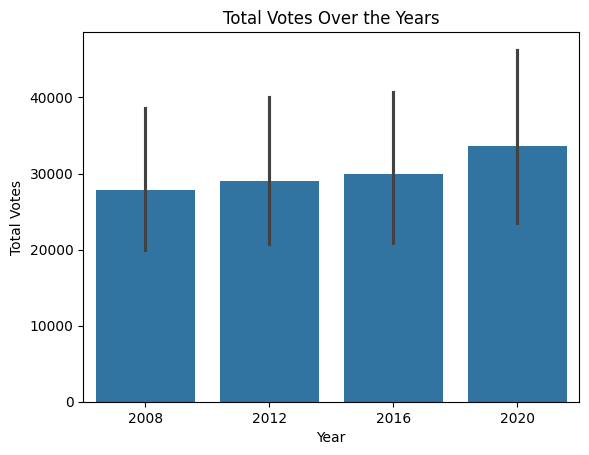

In [ ]:
# Total Votes over the year
sns.barplot(x='year', y='totalvotes', data=df)
plt.title('Total Votes Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.show()

## Stacked Barplot: Party Vote Share by Year (Republican vs. Democrat)

We then explore the percentage of party votes for democrats and republicans within each year (Figure 2). For each year, there is almost an even split between Democrats and Republicans, with the majority of votes being for Democratic party candidates by a small margin. Virginia has been a swing state in the past, with a slight preference toward Democratic candidates, as demonstrated in our figure. Based on previous years, this suggests that the 2024 election may follow a similar trend.

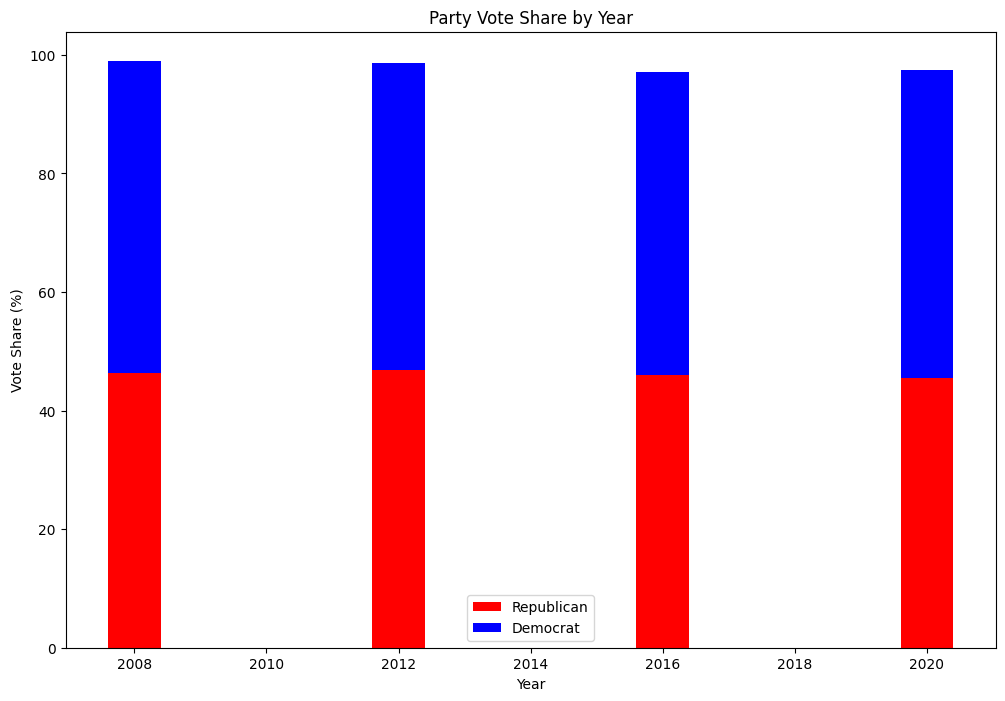

      Total Republican  Total Democrat  totalvotes  Republican Share  \
year                                                                   
2008           1725005         1959532     3723260         46.330501   
2012           1820995         1970595     3851684         46.812227   
2016           1769443         1981473     3984631         45.983031   
2020           1962430         2413568     4462600         45.423752   

      Democrat Share  
year                  
2008       52.629470  
2012       51.883248  
2016       51.140288  
2020       51.960286  


In [ ]:
# Party Vote Share by Year (Republican vs. Democrat)
grouped_df = df.groupby('year').sum()

# Calculate cumulative party vote shares as percentages
grouped_df['Republican Share'] = (grouped_df['Total Republican'].cumsum() / grouped_df['totalvotes'].cumsum()) * 100
grouped_df['Democrat Share'] = (grouped_df['Total Democrat'].cumsum() / grouped_df['totalvotes'].cumsum()) * 100

# Create stacked bar plot
plt.figure(figsize=(12, 8))
plt.bar(grouped_df.index, grouped_df['Republican Share'], label='Republican', color='red')
plt.bar(grouped_df.index, grouped_df['Democrat Share'], bottom=grouped_df['Republican Share'], label='Democrat', color='blue')
plt.xlabel('Year')
plt.ylabel('Vote Share (%)')
plt.title('Party Vote Share by Year')
plt.legend()
plt.show()

print(grouped_df[['Total Republican', 'Total Democrat', 'totalvotes', 'Republican Share', 'Democrat Share']])

We explore the net vote, defined as votes for Republican - votes for Democrats for a given county. We sum net votes within a given year to determine outcome of the election. In recent years, Democratic candidates have won the presidential elections in Virginia. The margin that Democrats won by in Virginia doubled in 2020.

We use ne

In [7]:
summary_df = df.groupby('year')['Net Vote'].sum().reset_index()
print(summary_df)

   year  Net Vote
0  2008   -234527
1  2012   -149600
2  2016   -212030
3  2020   -451138


## add title here

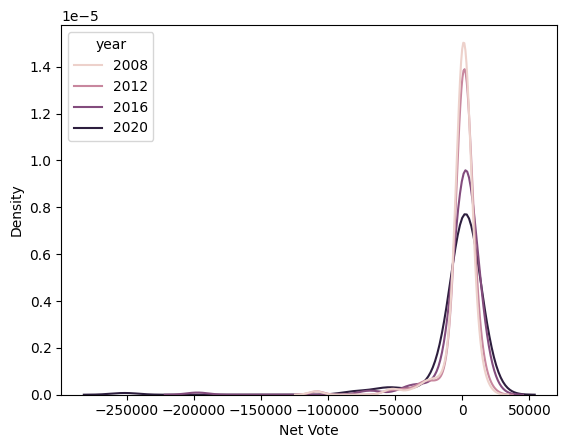

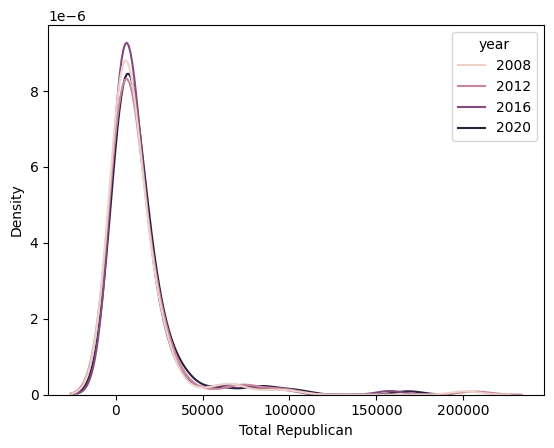

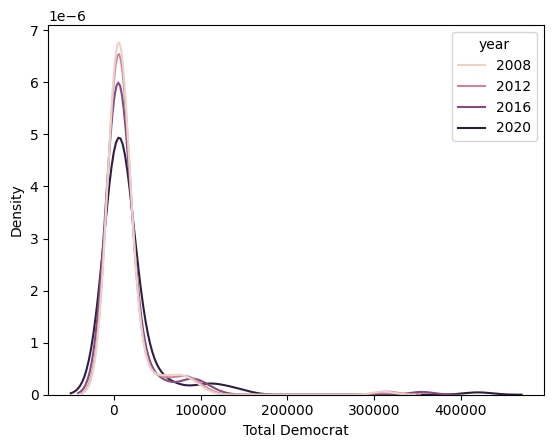

In [ ]:
import seaborn as sns

# kde plot of year vs. Net Vote, Total Republican, Total Democrat
sns.kdeplot(data=df, x='Net Vote', hue = 'year')
plt.show()

sns.kdeplot(data=df, x='Total Republican', hue = 'year')
plt.show()

sns.kdeplot(data=df, x='Total Democrat', hue = 'year')
plt.show()

In [ ]:
# take arcsinh of Net Vote (rescale it and make it easier for regressions and trees to fit the realized range of values)

df['arcsinh Net Vote'] = np.arcsinh(df['Net Vote'])
sns.kdeplot(data=df, x='arcsinh Net Vote', hue='year')
plt.show()


df['arcsinh Total Republican'] = np.arcsinh(df['Total Republican'])
sns.kdeplot(data=df, x='arcsinh Total Republican', hue='year')
plt.show()


df['arcsinh Total Democrat'] = np.arcsinh(df['Total Democrat'])
sns.kdeplot(data=df, x='arcsinh Total Democrat', hue='year')
plt.show()

NameError: name 'np' is not defined

KDE plot (set 2) conclusion: The following KDE plots graph net votes, total republican votes and total democrats votes across the election years, rescaled by arcsinh. When applying arcsinh, a large value (postive or negative) will be compressed and small value will be expanded. Readability improves as seen by the obvious peaks in the graphs verses the nontransformed graphs that had small peaks that were almost indistinguishable unless carefully looking. More specifically, the bimodal graph that arcsinh net vote creates shows that there are two main counts that had the highest proportion consistently across all elections years. It also appears that when looking at this graph, no one year dominated at the peak showing that there isn't an obvious trend as to how net vote counts has changed over the years.

# **Conclusion**

# **Appendix**